In [28]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); 
Pkg.instantiate()
using ForwardDiff
using Test
using RobotZoo: PlanarQuadrotor
using RobotDynamics
# using LinearAlgebra
using StaticArrays
# using SparseArrays
using Plots
# using Printf

include("quadratic_cost.jl")
include("quadrotor.jl")

  Activating environment at `~/devel/optimal_control/hw3_solutions/Project.toml`


run_tests (generic function with 1 method)

# Question 1: Iterative LQR (50 pts)
In this problem you'll implement iterative LQR (ilQR), the Gauss-Newton approximation of differential dynamic programming (DDP). You'll use it to generate trajectories for a planar quadrotor, including a flip. In the last part of the problem, you'll track the trajectory to make it robust to wind.

## The Model
We'll be using the same planar quadrotor model we saw in class. The dynamics are fairly simple:

$$ 
x = \begin{bmatrix} p_x \\ p_z \\ \theta \\ v_x \\ v_z \\ \omega \end{bmatrix}, \quad
\dot{x} = \begin{bmatrix} v_x \\ v_z \\ \omega \\ 
\frac{1}{m} (u_1 + u_2) \sin{\theta} \\
\frac{1}{m} (u_1 + u_2) \cos{\theta} - g \\
\frac{l}{J} (u_2 - u_1) 
\end{bmatrix}
$$
with the following model parameters:
* $m$: mass (kg)
* $J$: moment of inertia
* $l$: distance between motors

In [29]:
# dynamics stuff
using LinearAlgebra
const FD = ForwardDiff
function dynamics(x,u)
    # planar quadrotor dynamics
    
    # parameters
    mass = 1.0 
    g = 9.81
    ℓ = 0.3 
    J = 0.2*mass*ℓ^2

     # unpack state
    px,pz,θ,vx,vz,ω = x    
    return [vx,vz,ω,(1/mass)*(u[1] + u[2])*sin(θ), (1/mass)*(u[1] + u[2])*cos(θ) - g, (ℓ/(2*J))*(u[2]-u[1])]
end

function rk4(x,u,dt)
    # rk4 for integration
    k1 = dt*dynamics(x,u)
    k2 = dt*dynamics(x + k1/2,u)
    k3 = dt*dynamics(x + k2/2,u)
    k4 = dt*dynamics(x + k3,u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

function dynamics_jacobians(x,u,dt)
    # returns the discrete time dynamics jacobians
    A = FD.jacobian(_x -> rk4(_x,u,dt),x)
    B = FD.jacobian(_u -> rk4(x,_u,dt),u)
    return A,B
end

dynamics_jacobians (generic function with 1 method)

In [30]:
# cost expansion 
function stage_cost(x,u,xref,uref)
    # LQR cost at each knot point (depends on both x and u)
    0.5*(x - xref)'*Q*(x - xref) + 0.5*(u - uref)'*R*(u - uref)
end

function term_cost(x,xref)
    # LQR terminal cost (depends on just x)
    0.5*(x - xref)'*Qf*(x - xref)
end

function trajectory_cost(X,U,Xref,Uref)
    # calculate the cost of a given trajectory 
    J = 0.0
    for i = 1:(T-1)
        J += stage_cost(X[i],U[i],Xref[i],Uref[i])
    end
    J += term_cost(X[T],Xref[T])
    return J
end
        
function stage_cost_expansion(x,u,xref,uref)
    # if the cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ, ∇²ᵤJ, ∇ᵤJ
    Jxx = Q
    Jx = Q*(x - xref)
    Juu = R
    Ju = R*(u - uref)
    return Jxx, Jx, Juu, Ju
end

function term_cost_expansion(x,xref)
    # if the terminal cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ
    Jxx = Qf
    Jx = Qf*(x - xref)
    return Jxx, Jx
end

term_cost_expansion (generic function with 1 method)

In [31]:
function backward_pass(X,U,Xref,Uref)

    # allocate all our data
    P = [zeros(nx,nx) for i = 1:T]   # cost to go quadratic term
    p = [zeros(nx) for i = 1:T]      # cost to go linear term 
    d = [zeros(nu) for i = 1:T-1]    # feedforward control
    K = [zeros(nu,nx) for i = 1:T-1] # feedback gain
    ΔJ = 0.0                         # expected cost decrease


    # terminal cost expansion
    P[T],p[T] = term_cost_expansion(X[T],Xref[T])
    
    for k = (T-1):(-1):1
        
        # dynamics jacobians 
        A,B = dynamics_jacobians(X[k],U[k],dt)
        
        # cost expansion 
        Jxx, Jx, Juu, Ju = stage_cost_expansion(X[k],U[k],Xref[k],Uref[k])
        
        # Q expansion 
        gx = Jx + A'*p[k+1]
        gu = Ju + B'*p[k+1]
    
        Gxx = Jxx + A'*P[k+1]*A
        Guu = Juu + B'*P[k+1]*B
        Gux = B'*P[k+1]*A
        
        # Calculate Gains
        d[k] = Guu\gu
        K[k] = Guu\Gux
    
        # Cost-to-go Recurrence
        p[k] = gx - K[k]'*gu + K[k]'*Guu*d[k] - Gux'*d[k]
        P[k] = Gxx + K[k]'*Guu*K[k] - Gux'*K[k] - K[k]'*Gux
        ΔJ += gu'*d[k]
    end
    
    return d, K, P, ΔJ
end

backward_pass (generic function with 1 method)

In [32]:
function forward_pass(X,U,Xref,Uref,K,d,ΔJ)
    
    Xn = deepcopy(X)
    Un = deepcopy(U)
    α = 1.0 
    J = trajectory_cost(X,U,Xref,Uref)

    for i = 1:10
        
        
        # Forward Rollout
        for k = 1:(T-1)
            Un[k] = U[k] - α*d[k] - K[k]*(Xn[k]-X[k])
            Xn[k+1] = rk4(Xn[k],Un[k],dt)
        end
        Jn = trajectory_cost(Xn,Un,Xref,Uref)
        
        # armijo line search
        if Jn< (J - 1e-2*α*ΔJ)
            return Xn, Un, J, α
        else
            α *= 0.5
        end
    end
    error("forward pass failed")
end

forward_pass (generic function with 1 method)

In [33]:
using Printf
function iLQR(x0,U,Xref,Uref)
    
    # inital logging stuff 
    @printf "iter     J           ΔJ        |d|         α\n"
    @printf "-----------------------------------------------\n"
    
    # initial rollout 
    X = [zeros(nx) for i = 1:(length(U)+1)]
    X[1] = deepcopy(x0)
    for i = 1:T-1
        X[i+1] = rk4(X[i],U[i],dt)
    end
    
    for iter = 1:100
        
        d, K, P, ΔJ = backward_pass(X,U,Xref,Uref)
        
        # termination criteria
        if maximum(norm.(d))<1e-5
            return X,U,K,P
        end
        
        X, U, J,α = forward_pass(X,U,Xref,Uref,K,d,ΔJ)
        
        # logging
        @printf("%3d   %10.3e  %9.2e  %9.2e  % 6.4f\n",
          iter, J, ΔJ, maximum(norm.(d)), α)
        
    end
    error("ilqr reached max iters")
end
        

iLQR (generic function with 1 method)

In [34]:
const x0    = [-3, 1, 0, 0, 0, 0]                    # initial state
const xgoal = [+3, 1, 0, 0, 0, 0]                    # goal state
const nx = 6 
const nu = 2
const uhover = fill(0.5*1.0 * 9.8, nu) 

const Q = Diagonal(([ones(3) ; fill(0.1, 3)]))
const R = Diagonal(fill(1e-2, nu))
const Qf = Diagonal(fill(1e2, nx));

const dt = 0.025 
const T = 61

Urand = [(.1*randn(nu) + uhover ) for k = 1:T-1]

Xrefline = [copy(xgoal) for i = 1:T]
Uref1line = [copy(uhover) for i = 1:T-1]
Xline,Uline,Kline,Pline = iLQR(x0,Urand,Xref1,Uref1);

iter     J           ΔJ        |d|         α
-----------------------------------------------


  1    3.105e+03   5.00e+03   7.41e+01   1.0000
  2    7.294e+02   5.24e+02   4.51e+01   1.0000
  3    5.525e+02   1.56e+02   2.78e+01   1.0000
  4    4.894e+02   2.28e+01   1.68e+01   1.0000
  5    4.820e+02   7.22e+00   7.96e+00   1.0000
  6    4.797e+02   2.34e+00   4.80e+00   1.0000
  7    4.791e+02   9.85e-01   2.90e+00   1.0000
  8    4.789e+02   4.11e-01   1.87e+00   1.0000
  9    4.788e+02   1.98e-01   1.26e+00   1.0000
 10    4.788e+02   9.16e-02   8.22e-01   1.0000
 11    4.788e+02   4.56e-02   5.93e-01   1.0000
 12    4.788e+02   2.19e-02   3.96e-01   1.0000
 13    4.788e+02   1.10e-02   2.88e-01   1.0000
 14    4.788e+02   5.35e-03   1.97e-01   1.0000
 15    4.788e+02   2.66e-03   1.41e-01   1.0000
 16    4.788e+02   1.31e-03   9.80e-02   1.0000
 17    4.788e+02   6.51e-04   6.95e-02   1.0000
 18    4.788e+02   3.21e-04   4.86e-02   1.0000
 19    4.788e+02   1.59e-04   3.43e-02   1.0000
 20    4.788e+02   7.88e-05   2.41e-02   1.0000
 21    4.788e+02   3.90e-05   1.70e-02  

In [35]:
# # Problem Setup
model = PlanarQuadrotor()
# n,m = size(model)          # state and control dimensions
# dt = 0.025                 # time step (sec)
# tf = 1.5                   # time horizon (sec)
# T = Int(tf/dt) + 1         # number of time steps

# # Initial & final condition
# x0    = SA_F64[-3, 1, 0, 0, 0, 0]                    # initial state
# xgoal = SA_F64[+3, 1, 0, 0, 0, 0]                    # goal state
# uhover = @SVector fill(0.5*model.mass * model.g, m)  # hover controls

# # Cost matrices
# Q = Diagonal(SVector{6}([ones(3) ; fill(0.1, 3)]))
# R = Diagonal(@SVector fill(1e-2, m))
# Qf = Diagonal(@SVector fill(1e2, n));

# @show model.mass
# @show model.J
# @show model.ℓ

## Part (a): Implement iLQR
Implement iLQR by completing the provided methods. We provide the following struct that stores the problem definition. Reference the cells below for a brief example of using this struct.

In [36]:
# """
#     Problem{n,m,L}

# Describes a trajectory optimization problem with `n` states, `m` controls, and 
# a model of type `L`. 

# # Constructor
#     Problem(model::L, obj::Vector{<:QuadraticCost{n,m}}, tf, x0, xf) where {n,m,L}

# where `tf` is the final time, and `x0` is the initial state. 
# """
# struct Problem{n,m,L}
#     model::L
#     obj::Vector{QuadraticCost{n,m,Float64}}
#     T::Int
#     tf::Float64
#     x0::MVector{n,Float64}
#     times::Vector{Float64}
#     function Problem(model::L, obj::Vector{<:QuadraticCost{n,m}}, tf, x0) where {n,m,L}
#         @assert length(x0) == n == length(obj[1].q) == state_dim(model)
#         @assert length(obj[1].r) == m == control_dim(model)
#         T = length(obj)
#         times = range(0, tf, length=T)
#         new{n,m,L}(model, obj, T, tf, x0, times)
#     end
# end
# Base.size(prob::Problem{n,m}) where {n,m} = (n,m,prob.T)

In [37]:
# # Cost function
# cost_stage = LQRCost(Q, R, xgoal, uhover)
# cost_term = LQRCost(Qf, R, xgoal, uhover)
# obj = [cost_stage for k = 1:T-1]
# push!(obj, cost_term)

# # Build Problem
# prob = Problem(model, obj, tf, x0);
# n,m,T = size(prob)   # get problem dimensions

# # Random trajectory
# Xrand = [@SVector randn(n) for k = 1:T]
# Urand = [@SVector randn(m) for k = 1:T-1]

# # Evaluate the cost
# t = prob.times[1]
# dt = prob.times[2]-prob.times[1]
# cost(prob.obj, Xrand, Urand)

# # Evaluate the dynamics
# discrete_dynamics(RK4, prob.model, Xrand[1], Urand[1], t, dt)
# ∇f = zeros(n,n+m)
# discrete_jacobian!(RK4, ∇f, prob.model, Xrand[1], Urand[1], t, dt)

In [38]:
# ?LQRCost  # run this to print docstring for LQRCost

In [39]:
# ?QuadraticCost  # run this to print docstring for QuadraticCost

### Cost and Dynamics Derivatives

In [40]:
# # TASK: Complete the code below for the backward pass
# """
#     backwardpass!(prob, P, p, K, d, X, U)

# Evaluate the iLQR backward pass at state and control trajectories `X` and `U`, 
# storing the cost-to-go expansion in `P` and `p` and the gains in `K` and `d`.

# Should return ΔJ, expected cost reduction.
# """
# function backwardpass!(prob::Problem{n,m}, P, p, K, d, X, U; 
#         β=1e-6, ddp::Bool=false
#     ) where {n,m}
#     T = prob.T
#     obj = prob.obj
#     ΔJ = 0.0
#     failed = false
    
#     # TODO: Implement the backward pass

#     # SOLUTION
#     ∇f = RobotDynamics.DynamicsJacobian(prob.model) # give this to them
#     ∇jac = zeros(n+m,n+m) 

#     p[T] = obj[end].Q*X[T] + obj[end].q
#     P[T] = obj[end].Q
# #     P[T], p[T] = cost_expansion(obj[end],X[T])
    
#     #Backward Pass
#     failed = false
#     for k = (T-1):-1:1
#         # Cost Expansion
#         q = obj[k].Q*X[k] + obj[k].q
#         Q = obj[k].Q
#         r = obj[k].R*U[k] + obj[k].r
#         R = obj[k].R
# #         Q,q,R,r = cost_expansion(obj[k],X[k],U[k])

#         # Dynamics derivatives
#         dt = prob.times[k+1] - prob.times[k]
#         A,B = dynamics_jacobians(model,∇f, dt, X[k], U[k])
#         z = KnotPoint(SVector{n}(X[k]), SVector{m}(U[k]), dt, prob.times[k])
#         discrete_jacobian!(RK4, ∇f, model, z)
#         A = RobotDynamics.get_static_A(∇f)
#         B = RobotDynamics.get_static_B(∇f)
    
#         gx = q + A'*p[k+1]
#         gu = r + B'*p[k+1]
    
#         Gxx = Q + A'*P[k+1]*A
#         Guu = R + B'*P[k+1]*B
#         Gux = B'*P[k+1]*A
        
#         if ddp 
#             # #Add full Newton terms
#             RobotDynamics.∇discrete_jacobian!(RK4, ∇jac, model, z, p[k+1])
#             Gxx .+= ∇jac[1:n, 1:n]
#             Guu .+= ∇jac[n+1:end, n+1:end]
#             Gux .+= ∇jac[n+1:end, 1:n]
#         end
    
#         # Regularization
#         Gxx_reg = Gxx + A'*β*I*A
#         Guu_reg = Guu + B'*β*I*B
#         Gux_reg = Gux + B'*β*I*A
#         C = cholesky(Symmetric([Gxx_reg Gux_reg'; Gux_reg Guu_reg]), check=false)
#         if !issuccess(C)
#             β = 2*β
#             failed = true
#             break
#         end
        
#         # Calculate Gains
#         d[k] .= Guu_reg\gu
#         K[k] .= Guu_reg\Gux_reg
    
#         # Cost-to-go Recurrence
#         p[k] .= gx - K[k]'*gu + K[k]'*Guu*d[k] - Gux'*d[k]
#         P[k] .= Gxx + K[k]'*Guu*K[k] - Gux'*K[k] - K[k]'*Gux
#         ΔJ += gu'*d[k]
#     end
#     return ΔJ
# end

### Forward Pass

In [41]:
# # TASK: Complete the method for the forward pass
# """
#     forwardpass!(prob, X, U, K, d, ΔJ, J)

# Evaluate the iLQR forward pass at state and control trajectories `X` and `U`, using
# the gains `K` and `d` to simulate the system forward. The new cost should be less than 
# the current cost `J` together with the expected cost decrease `ΔJ`.

# Should return the new cost `Jn` and the step length `α`.
# """
# function forwardpass!(prob::Problem{n,m}, X, U, K, d, ΔJ, J,
#         Xbar = deepcopy(X), Ubar = deepcopy(U);
#         max_iters=10,
#     ) where {n,m}
#     T = prob.T

#     # TODO: Implement the forward pass w/ line search
#     Jn = J
#     α = 0.0
    
#     # SOLUTION
#     # Line Search
#     Xbar[1] = X[1]
#     α = 1.0
#     Jn = Inf
#     for i = 1:max_iters
        
#         # Forward Rollout
#         for k = 1:(T-1)
#             t = prob.times[k]
#             dt = prob.times[k+1] - prob.times[k]
#             Ubar[k] = U[k] - α*d[k] - K[k]*(Xbar[k]-X[k])
#             Xbar[k+1] = discrete_dynamics(RK4, model, Xbar[k], Ubar[k], t, dt) 
#         end
        
#         # Calculate the new cost
#         Jn = cost(prob.obj, Xbar, Ubar)

#         # Check Armijo condition
#         if Jn <= J - 1e-2*α*ΔJ
#             break
#         else
#             # Backtrack
#             α *= 0.5  
#         end
#         if i == max_iters 
#             @warn "Line Search failed"
#             α = 0
#         end
#     end
    
#     # Accept direction
#     for k = 1:T-1
#         X[k] = Xbar[k]
#         U[k] = Ubar[k]
#     end
#     X[T] = Xbar[T]
    
#     return Jn, α
# end


### iLQR Algorithm

In [42]:
# # TASK: Complete the code below to implement iLQR
# """
#     solve_ilqr(prob, X, U; kwargs...)

# Solve the trajectory optimization problem specified by `prob` using iterative LQR.
# Returns the optimized state and control trajectories, as well as the local control gains,
# `K` and `d`.

# Should return the optimized state and control trajectories `X` and `U`, and the 
# list of feedback gains `K` and cost-to-go hessians `P`.
# """
# function solve_ilqr(prob::Problem{n,m}, X0, U0; 
#         iters=100,     # max iterations
#         ls_iters=10,   # max line search iterations
#         reg_min=1e-6,  # minimum regularizatio for the backwardpass
#         verbose=0,     # print verbosity
#         eps=1e-5,      # termination tolerance
#         eps_ddp=eps    # tolerance to switch to ddp
#     ) where {n,m}
#     t_start = time_ns()
#     Nx,Nu,Nt = size(prob)

#     # Initialization
#     T = prob.T
#     p = [zeros(n) for k = 1:T]      # ctg gradient
#     P = [zeros(n,n) for k = 1:T]    # ctg hessian
#     d = [zeros(m) for k = 1:T-1]    # feedforward gains
#     K = [zeros(m,n) for k = 1:T-1]  # feedback gains
#     Xbar = [@SVector zeros(n) for k = 1:T]    # line search trajectory
#     Ubar = [@SVector zeros(m) for k = 1:T-1]  # line search trajectory
#     ΔJ = 0.0

#     # Don't modify the trajectories that are passed in
#     X = deepcopy(X0)
#     U = deepcopy(U0)

#     # Initial cost
#     J = cost(prob.obj, X, U)
    
#     # Initialize parameters
#     Jn = Inf
#     iter = 0
#     tol = 1.0
#     β = reg_min
#     while tol > eps 
#         iter += 1
        
#         # TODO: Implement iLQR
        
#         # SOLUTION
        
#         # Backward Pass
#         ddp = tol < eps_ddp
#         ΔJ = backwardpass!(prob, P, p, K, d, X, U, ddp=ddp, β=β)

#         # Forward Pass
#         Jn, α = forwardpass!(prob, X, U, K, d, ΔJ, J, Xbar, Ubar, max_iters=ls_iters)

#         # Update parameters
#         tol = maximum(norm.(d, Inf))
#         β = max(0.9*β, reg_min)
        
#         # END SOLUTION

#         # Output
#         if verbose > 0
#             @printf("Iter: %3d, Cost: % 6.2f → % 6.2f (% 7.2e), res: % .2e, β= %.2e, α = %.3f\n",
#                 iter, J, Jn, J-Jn, tol, β, α
#             )
#         end
#         J = Jn

#         if iter >= iters
#             @warn "Reached max iterations"
#             break
#         end

#     end
#     println("Total Time: ", (time_ns() - t_start)*1e-6, " ms")
#     return X,U,K,P
# end


## Part (b): Simple trajectory
Use your iLQR solver to move the quadrotor from the initial state to the goal state.

In [43]:
# # TASK: Solve for the optimized trajectories using iLQR
# #       Store the results in Xline, Uline

# # SOLUTION

# # Cost function
# cost_stage = LQRCost(Q, R, xgoal, uhover)
# cost_term = LQRCost(Qf, R, xgoal, uhover)
# obj = [cost_stage for k = 1:T-1]
# push!(obj, cost_term)

# # Build Problem
# prob = Problem(model, obj, tf, x0);

# # Initial Guess
# X0 = [x0 for k = 1:T]
# U0 = [uhover for k = 1:T-1]

# # Solve
# Xline, Uline = solve_ilqr(prob, X0, U0, verbose=1);

In [44]:
# SVector{6,Float64}::AbstractVector

In [19]:
vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /Users/kevintracy/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [45]:
visualize!(vis, model, dt*(T-1), Xline)

## Part (c): Generate Cost function for Flip
Generate a reference trajectory for the cost function. Since we're designing it by hand we'll do something simple. Complete the function below to generate a trajectory that does the following:
* 0.0-0.5 sec: Moves linearly from -2 to 0 in x
* 0.5-1.0 sec: Moves linearly from 1 to 3 and back to 1 in y. Rotates 360 degrees. No movement in x.
* 1.0-1.5 sec: Moves linearly from 0 to 3 in x.

The velocities should be consistent with the positions.

The trajectory should look like the following:
![flip_traj](flip_reference.png)

In [46]:
# TASK: Implement the following method
"""
    flip_reference

Generate a reference trajectory for the quadrotor that encourages it to do a flip.
The trajectory should have a length of 61.
"""
function flip_reference()
    # TODO: Design the reference trajectory according to the specs above
    x1ref = zeros(61)
    x2ref = zeros(61)
    θref = zeros(61)
    v1ref = zeros(61)
    v2ref = zeros(61)
    
    # SOLUTION
    x1ref = [LinRange(-3,0,20); zeros(20); LinRange(0,3,21)]
    x2ref = [ones(20); LinRange(1,3,10); LinRange(3,1,10); ones(21)]
    θref = [zeros(20); LinRange(0,-2*pi,20); -2*pi*ones(21)]
    v1ref = [6.0*ones(20); zeros(20); 6.0*ones(21)]
    v2ref = [zeros(20); 8.0*ones(10); -8.0*ones(10); zeros(21)]
    ωref = [zeros(20); -4*pi*ones(20); zeros(21)]
    # END SOLUTION
    
    xref = [x1ref'; x2ref'; θref'; v1ref'; v2ref'; ωref']
    return [SVector{6}(x) for x in eachcol(xref)]
end

flip_reference

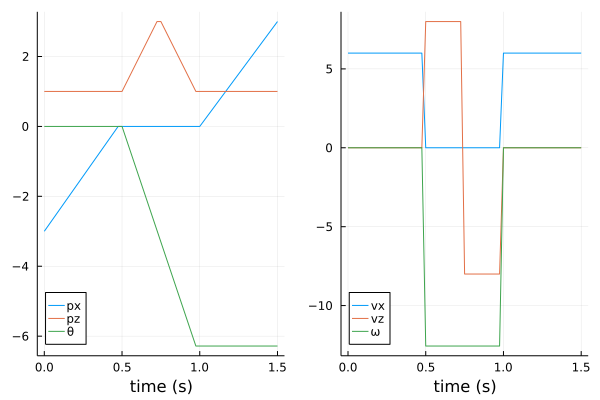

In [47]:
# Plot the reference trajectory
Xref = flip_reference()
p = plot(layout=(1,2))
# prob.times
time_vec= 0:dt:(T-1)*dt
plot!(p[1], time_vec, Xref, inds=1:3, xlabel="time (s)", labels = ["px" "pz" "θ"], legend=:bottomleft)
plot!(p[2], time_vec, Xref, inds=4:6, xlabel="time (s)", labels = ["vx" "vz" "ω"], legend=:bottomleft)

Generate a new time-varying objective that tracks the reference trajectory. Check out the types in `quadratic_cost.jl` for some convenient constructors.

In [48]:
# # TASK: design the time-varying tracking objective
# #       save it as the variable obj_flip::Vector{<:QuadraticCost}
# obj_flip = copy(obj)

# # SOLUTION
# Uref = [uhover for k = 1:T-1]
# obj_flip = map(1:T-1) do k
#     LQRCost(Q, R, Xref[k], Uref[k])
# end
# push!(obj_flip, LQRCost(Qf, R, Xref[end]));

## Part (d): Optimize the Flip Trajectory
Using the reference trajectory and the objective you specified in the previous part, construct a new problem and solve it with your iLQR solver. Use a simple hover trajectory as the initial guess.

In [49]:
# # TODO: Solve for Xflip, Uflip, the optimized trajectories to flip the quadrotor

# Xflip, Uflip, K, P = deepcopy(X0), deepcopy(U0), [zeros(m,n) for k = 1:T], [zeros(n,n) for k = 1:T]

# # SOLUTION
# prob_flip = Problem(model, obj_flip, tf, x0)

# # Initial guess
# X0 = [x0 for k = 1:T]
# U0 = [uhover for k = 1:T-1]

# Xflip, Uflip, K, P = solve_ilqr(prob_flip, X0, U0, verbose=1);
Uref = [copy(uhover) for i = 1:T-1]
Xflip,Uflip,Kflip,Pflip = iLQR(x0,Uref,Xref,Uref);

iter     J           ΔJ        |d|         α
-----------------------------------------------
  1    6.736e+03   1.06e+04   1.33e+02   1.0000
  2    6.453e+03   1.15e+04   2.45e+02   0.5000
  3    5.260e+03   9.16e+03   2.72e+02   1.0000
  4    1.576e+03   2.48e+03   1.08e+02   0.2500
  5    1.019e+03   1.33e+03   6.80e+01   0.5000
  6    6.227e+02   4.96e+02   4.73e+01   1.0000
  7    4.952e+02   4.12e+02   5.39e+01   0.5000
  8    3.461e+02   1.95e+02   2.89e+01   0.5000
  9    2.641e+02   1.51e+02   2.47e+01   0.5000
 10    2.031e+02   1.26e+02   2.55e+01   0.5000
 11    1.638e+02   6.86e+01   2.66e+01   1.0000
 12    1.413e+02   2.29e+01   1.04e+01   1.0000
 13    1.306e+02   1.35e+00   2.30e+00   1.0000
 14    1.299e+02   1.92e-03   1.55e-01   1.0000
 15    1.299e+02   3.54e-04   7.05e-02   1.0000
 16    1.299e+02   7.79e-05   3.08e-02   1.0000
 17    1.299e+02   1.82e-05   1.47e-02   1.0000
 18    1.299e+02   4.46e-06   6.74e-03   1.0000
 19    1.299e+02   1.14e-06   3.31e-03   1.

In [50]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [52]:
visualize!(vis, model, dt*(T-1), Xflip)

## Part (e): Compare to TVLQR
iLQR generates a local linear feedback controller. As we saw in class, the backwardpass in iLQR is basically TVLQR with some extra terms. However, as our trajectory converges to a stationary point, these extra linear terms should go to zero. When iLQR exits, theses local feedback gains should closely match the result out of TVLQR. Using your code from the previous homework, generate a TVLQR solution for the optimized flip trajectory, using the same cost matrices used in your iLQR solver. They should match to reasonable numerical precision.

In [53]:
# TODO: Generate Klqr, Plqr, the feedback and cost-to-go matrices from TVLQR
#       to track the optimized flip trajectory

# SOLUTION:
function tvlqr(A,B,Q,R,Qf)
    # Extract some variables
    T = length(A)+1
    n,m = size(B[1])
    P = [zeros(n,n) for k = 1:T]
    K = [zeros(m,n) for k = 1:T-1]
    
    P[end] .= Qf
    for k = reverse(1:T-1) 
        K[k] .= (R + B[k]'P[k+1]*B[k])\(B[k]'P[k+1]*A[k])
        P[k] .= Q + A[k]'P[k+1]*A[k] - A[k]'P[k+1]*B[k]*K[k]
    end
    
    return K,P
end

A = [zeros(nx,nx) for k = 1:T-1]
B = [zeros(nx,nu) for k = 1:T-1]
# ∇f = RobotDynamics.DynamicsJacobian(model)
for k = 1:T-1
#     discrete_jacobian!(RK4, ∇f, model, Xflip[k], Uflip[k], prob.times[k], dt)
#     A[k] .= ∇f.A
#     B[k] .= ∇f.B
    A[k],B[k] = dynamics_jacobians(Xflip[k],Uflip[k],dt)
end

Klqr,Plqr = tvlqr(A,B,Q,R,Qf);

In [54]:
@test maximum(norm.(Kflip - Klqr,Inf)) < 1e-3
@test maximum(norm.(Pflip - Plqr,Inf)) < 1e-3

Test Passed

## Part (f): Closed-Loop Tracking
Now that we've seen that the controller generated by iLQR is nearly identical to the TVLQR solution with the same cost matrices, let's use the iLQR gains to track our trajectory, and see how robust it is to wind gusts.

In [84]:
using Random
function simulate_with_noise(x0,Xflip,Uflip,Kflip,open_loop)
    
    X = [zeros(nx) for i = 1:T]
    U = [zeros(nu) for i = 1:T-1]
    X[1] = copy(x0)
    
    Random.seed!(1)
    for k = 1:(T-1)
        if open_loop
            U[k] = Uflip[k]
        else
            U[k] = Uflip[k] - Kflip[k]*(X[k]-Xflip[k])
        end

        X[k+1] = rk4(X[k],U[k],dt) + [.0;0;0;.1*randn(3)]
    end
    
    return X,U
end



Xlqr,Ulqr = simulate_with_noise(x0,Xflip,Uflip,Kflip,false)
Xopen,Uopen = simulate_with_noise(x0,Xflip,Uflip,Kflip,true)

# # TODO: Generate two controllers to use in the simulations below:
# #       1. LQR controller: Should use the time-varying gains from your iLQR solver
# #       2. Open loop: Should use the control trajectory from your iLQR. No feedback.
# #       Both controllers should be types that implement the `get_control(ctrl, x, t)` method
# #       TIP: Feel free to use structs from HW2

# """
#     LQRController

# A TVLQR controller that tracks the trajectory specified by `Xref` and `Uref`
# using the linear feedback gains `K`.
# """
# struct LQRController
#     # TODO: add the fields you need
#     # SOLUTION
#     K::Vector{Matrix{Float64}}
#     Xref::Vector{Vector{Float64}}
#     Uref::Vector{Vector{Float64}}
#     times::Vector{Float64}
# end

# function get_control(ctrl::LQRController, x, t)
#     # TODO: implement the controller
#     u = zeros(2)
#     # SOLUTION
#     k = get_k(ctrl, t)
#     K = ctrl.K[k]
#     u = ctrl.Uref[k] - K*(x - ctrl.Xref[k])
#     return u
# end

# """
#     OpenLoopController

# A controller that just applies an open-loop control policy of sending a 
# set trajectory of control values.
# """
# struct OpenLoopController
#     # TODO: add the fields you need
#     # SOLUTION
#     Xref::Vector{Vector{Float64}}
#     Uref::Vector{Vector{Float64}}
#     times::Vector{Float64}
# end

# function get_control(ctrl::OpenLoopController, x, t)
#     # TODO: implement the controller
#     u = zeros(2)
#     # SOLUTION
#     k = get_k(ctrl, t)
#     u = ctrl.Uref[k]
#     return u
# end

# # SOLUTION
# get_k(controller, t) = searchsortedlast(controller.times, t)

# # TODO: Generate controllers
# # lqr = LQRController()
# # openloop = OpenLoopController()

# # SOLUTION
# lqr = LQRController(K, Xflip, Uflip, prob.times);
# openloop = OpenLoopController(Xflip, Uflip, prob.times);
# # END SOLUTION

# @test get_control(lqr, Xflip[1], 0.0) - Uflip[1] ≈ zeros(2)

In [78]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [79]:
# Simulate with LQR
visualize!(vis, model, dt*(T-1), Xlqr)

In [80]:
visualize!(vis, model, dt*(T-1), Xopen)

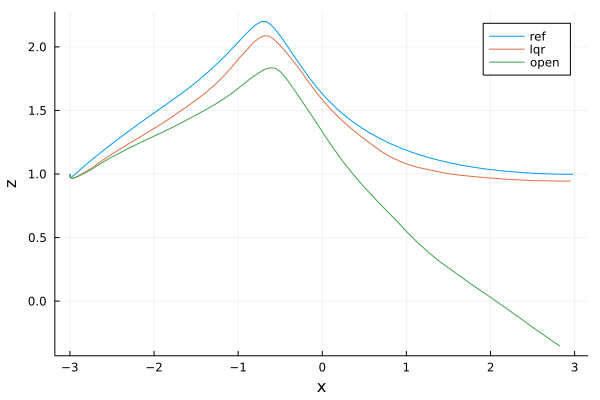

In [85]:
# Plot the trajectories
Xflip = SVector{nx}.(Xflip)
Xlqr = SVector{nx}.(Xlqr)
Xopen = SVector{nx}.(Xopen)
traj2(Xflip, label="ref")
traj2!(Xlqr, label="lqr")
traj2!(Xopen, label="open", ylabel="z")